## Задание 1

In [1]:
%pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
def read_gff(file):
    return pd.read_csv(f'{file}', 
                       sep = '\t',
                       comment='#',
                       names=['chromosome', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])

def read_bed6(file):
    return pd.read_csv(f'{file}', 
                       sep='\t',
                       names=['chromosome', 'start', 'end','name', 'score', 'strand'])


rrna_annotation = read_gff('data/rrna_annotation.gff')
rrna_annotation['attributes'] = rrna_annotation['attributes'] \
    .replace(['Name=16S_rRNA.*$', 'Name=23S_rRNA.*$','Name=5S_rRNA.*$'], 
             ['16S', '23S', '5S'],
             regex=True)
alignment = read_bed6('data/alignment.bed')

rna_23s = rrna_annotation[rrna_annotation['attributes'] == '23S']['chromosome'].value_counts().rename('23S')
rna_16s = rrna_annotation[rrna_annotation['attributes'] == '16S']['chromosome'].value_counts().rename('16S')
rna_5s = rrna_annotation[rrna_annotation['attributes'] == '5S']['chromosome'].value_counts().rename('5S')

rna_count_table = pd.concat([rna_5s, rna_16s, rna_23s], axis = 1) \
    .sort_index() \
    .reset_index(level=0) \
    .rename({'index' : 'Sequence'}, axis = 'columns')

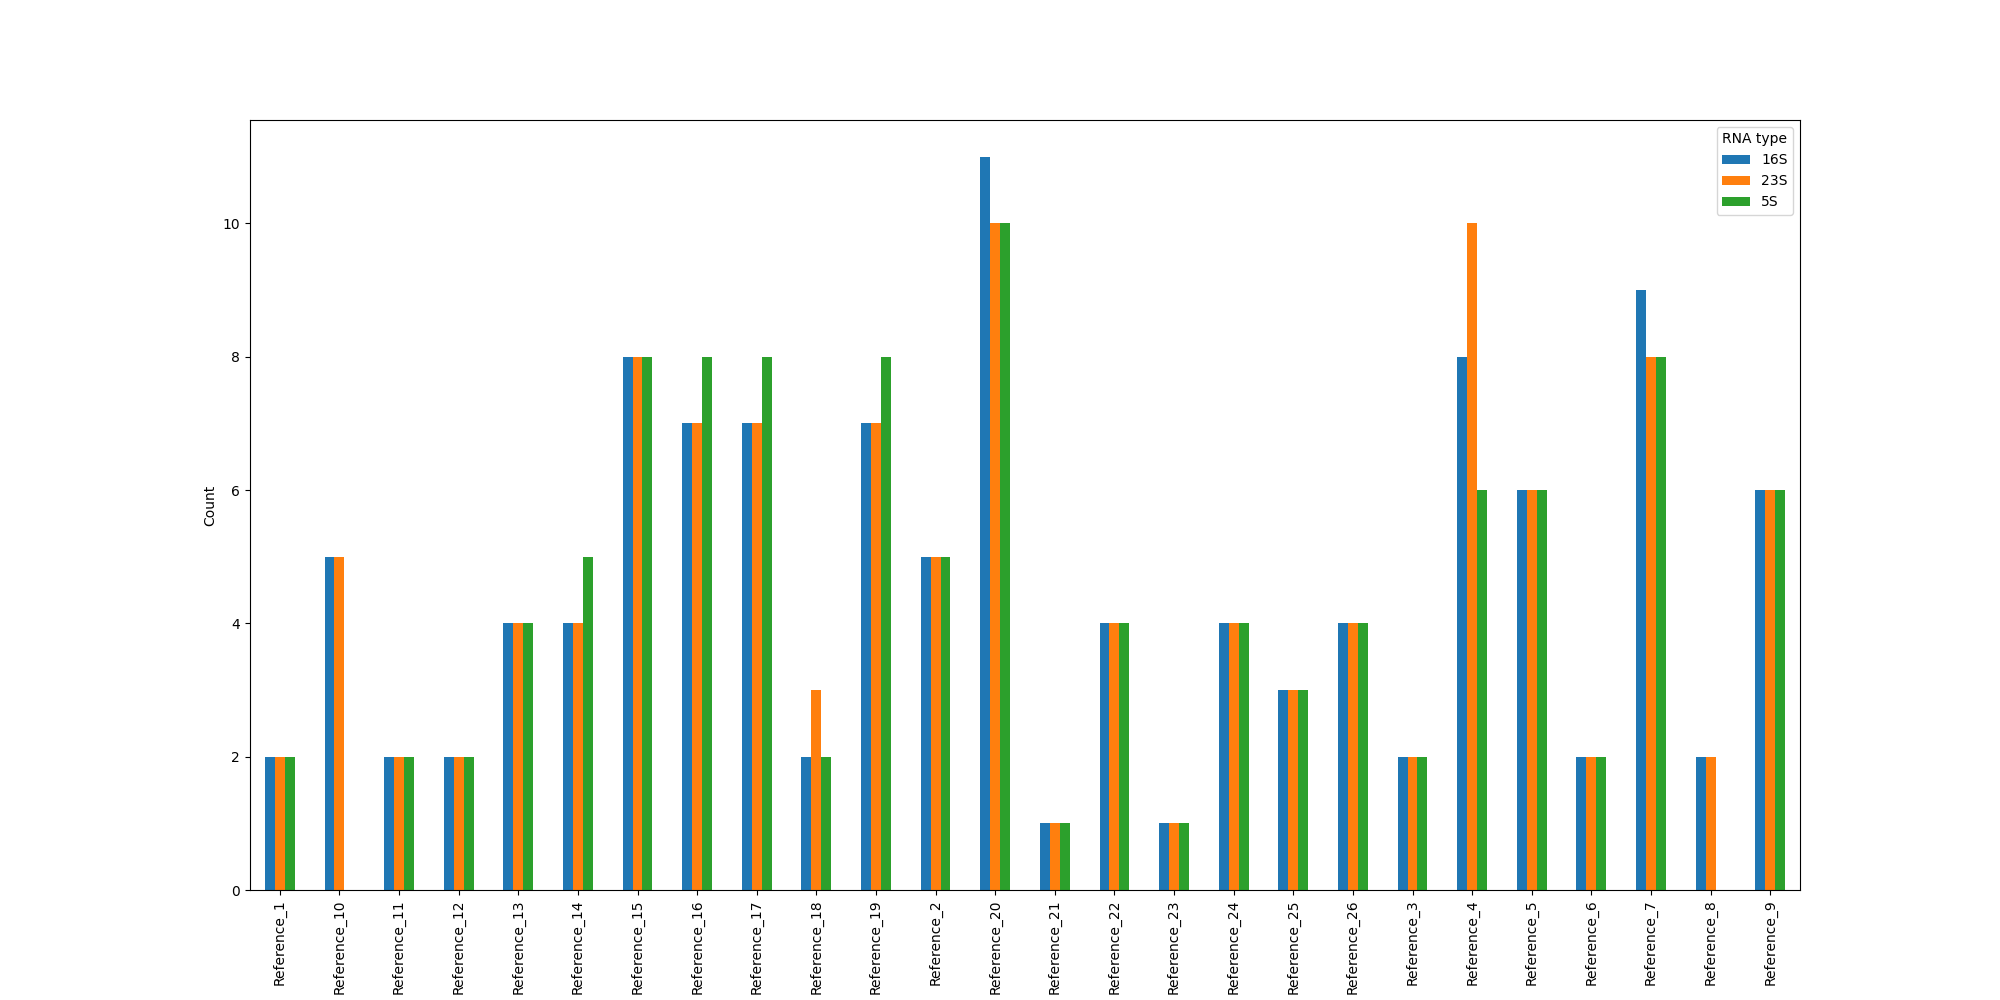

In [4]:
plt.figure(0)
rna_count_table.plot(x='Sequence', y=['16S', '23S', '5S'], kind='bar', figsize=(20,10))
plt.ylabel('Count')
plt.legend(title='RNA type')
plt.show()

In [5]:
rrna_annotation['annotation_interval'] = rrna_annotation.apply(lambda row: (row.start, row.end), axis = 1)
alignment['alignment_interval'] = alignment.apply(lambda row: (row.start - 1, row.end + 1), axis = 1)
merged = rrna_annotation.merge(alignment, on='chromosome')
merged = merged[merged.apply(lambda row : 
                                 row.alignment_interval[0] >= row.annotation_interval[0] and 
                                 row.alignment_interval[1] <= row.annotation_interval[1],
                             axis = 1)]
merged.drop(['annotation_interval', 'alignment_interval'], axis=1, inplace=True)
merged

,chromosome,source,type,start_x,end_x,score_x,strand_x,phase,attributes,start_y,end_y,name,score_y,strand_y
0,Reference_10,barrnap:0.9,rRNA,67122,68652,0.0,+,.,16S,67964,68037,NODE_19846_length_73_cov_334.777778,0,+
66,Reference_10,barrnap:0.9,rRNA,3633020,3634549,0.0,-,.,16S,3633634,3633707,NODE_19846_length_73_cov_334.777778,0,-
1973,Reference_13,barrnap:0.9,rRNA,2813625,2816528,0.0,-,.,23S,2814019,2814599,NODE_4348_length_580_cov_98.356190,0,-
5051,Reference_13,barrnap:0.9,rRNA,3429502,3432405,0.0,+,.,23S,3431430,3432010,NODE_4348_length_580_cov_98.356190,0,+
7935,Reference_13,barrnap:0.9,rRNA,3601172,3604075,0.0,+,.,23S,3603100,3603680,NODE_4348_length_580_cov_98.356190,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122288,Reference_14,barrnap:0.9,rRNA,3767193,3770101,0.0,-,.,23S,3767346,3768333,NODE_2899_length_987_cov_2309.247854,0,-
122289,Reference_14,barrnap:0.9,rRNA,3767193,3770101,0.0,-,.,23S,3768278,3768776,NODE_4995_length_498_cov_1324.878104,0,+
122290,Reference_14,barrnap:0.9,rRNA,3767193,3770101,0.0,-,.,23S,3769622,3770058,NODE_5664_length_436_cov_1749.713911,0,+
122396,Reference_14,barrnap:0.9,rRNA,3770571,3772040,0.0,-,.,16S,3771551,3772039,NODE_5081_length_488_cov_1763.796767,0,-


## Задание 2

In [6]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams
import heapq

In [7]:
diffexpr_data = pd.read_csv('data/diffexpr_data.tsv.gz', sep='\t')

In [8]:
def regulation(table: pd.DataFrame) -> str:
    log_fc, p_val = table
    if log_fc < 0 and p_val < 0.05:
        return 'Significantly down-regulated'
    if log_fc < 0 and p_val > 0.05:
        return 'Non-significantly down-regulated'
    if log_fc > 0 and p_val < 0.05:
        return 'Significantly up-regulated'
    return 'Non-significantly up-regulated'

diffexpr_data['regulation'] = diffexpr_data[['logFC', 'pval_corr']].apply(regulation, axis=1)

colors_map = {
    'Significantly down-regulated': '#1F77B4', 
    'Significantly up-regulated': '#FF7F0E', 
    'Non-significantly down-regulated': '#2CA02C', 
    'Non-significantly up-regulated': '#D62728'
}

bound = max(abs(diffexpr_data['logFC'])) + 1
plot_x_limits = [-bound, bound]

def significant_points(df: pd.DataFrame):
    up_regulated = df.loc[(df['regulation'] == 'Significantly up-regulated') & (df['pval_corr'] < 0.05)]
    down_regulated = df.loc[(df['regulation'] == 'Significantly down-regulated') & (df['pval_corr'] < 0.05)]
    reg = heapq.nlargest(2, up_regulated['logFC']) + [-x for x in heapq.nlargest(2, abs(down_regulated['logFC']))]
    return map(lambda reg_item: (
        reg_item, 
        df.loc[df['logFC'] == float(reg_item), 'Sample'].iloc[0],
        df.loc[df['logFC'] == float(reg_item), 'log_pval'].iloc[0]
    ), reg)

significant = significant_points(diffexpr_data)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


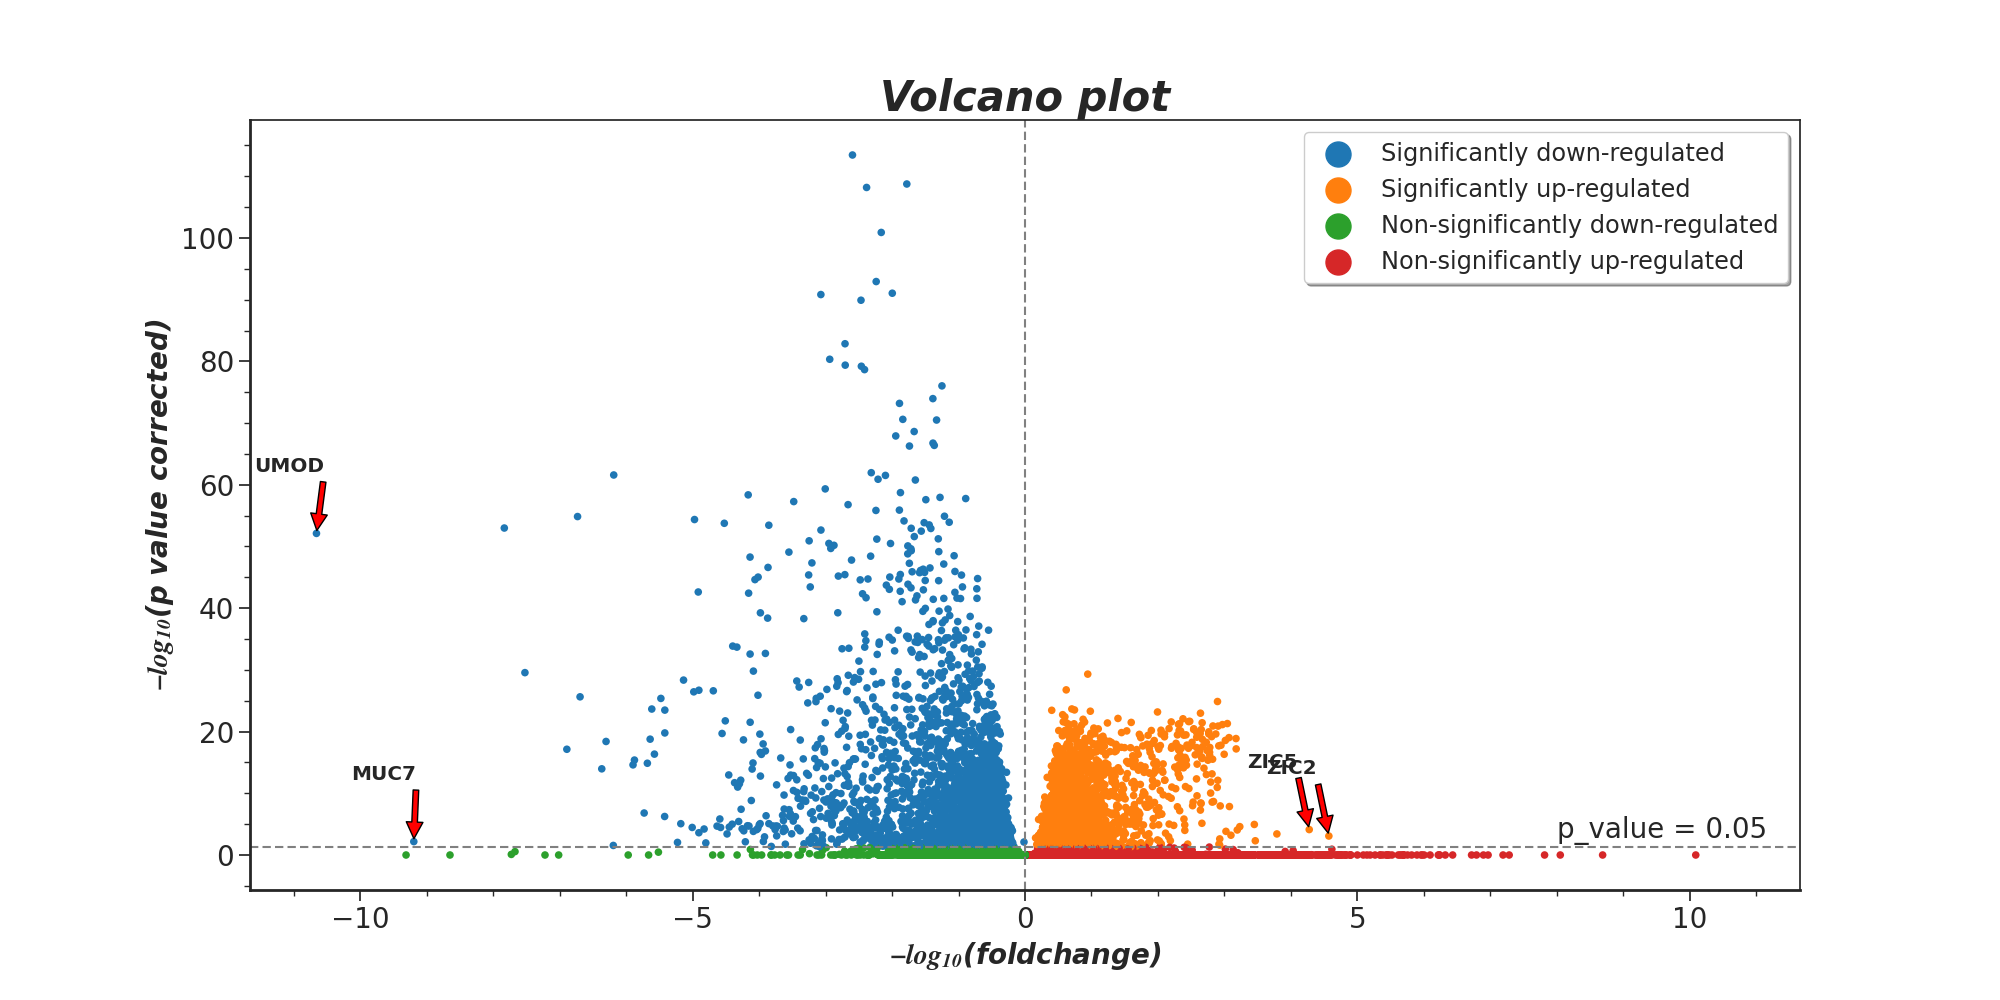

In [9]:
plt.figure(1)
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

sns.set(rc={'figure.figsize':(20,13), "xtick.bottom" : True, "ytick.left" : True})
sns.set_style('ticks')

volcano_plot = sns.scatterplot(data=diffexpr_data,
                               x='logFC', y='log_pval', 
                               hue='regulation', 
                               hue_order = [
                                   'Significantly down-regulated', 
                                   'Significantly up-regulated', 
                                   'Non-significantly down-regulated', 
                                   'Non-significantly up-regulated'
                               ], 
                               palette=colors_map, 
                               s=30,
                               linewidth=0)

volcano_plot.legend_.set_title(None)
legend = volcano_plot.legend(fontsize='x-large', markerscale=3, shadow=True)

volcano_plot.axvline(0, 
                     color='grey', 
                     dashes = (4,2), 
                     lw=1.5)
volcano_plot.axhline(-np.log10(0.05), 
                     color='grey',
                     dashes = (4,2),
                     lw=1.5,
                     label='p_value = 0.05')
volcano_plot.text(8,
                  -np.log10(0.05) + 1.5, 
                  'p_value = 0.05', 
                  fontsize=20)

volcano_plot.set_title('Volcano plot', 
                       weight='bold',
                       style='italic',
                       fontsize=30)
volcano_plot.set_xlabel(r'$\mathbf{-log_{10}}$(foldchange)',
                        weight='bold', 
                        style='italic', 
                        fontsize=20)
volcano_plot.set_ylabel(r'$\mathbf{-log_{10}}$(p value corrected)',
                        weight='bold', 
                        style='italic', 
                        fontsize=20)

volcano_plot.xaxis.set_minor_locator(AutoMinorLocator())
volcano_plot.yaxis.set_minor_locator(AutoMinorLocator())
volcano_plot.tick_params(which='major', labelsize=20, length = 8)
volcano_plot.tick_params(which='minor', length=4)

volcano_plot.set_xlim(plot_x_limits)
volcano_plot.spines['left'].set_linewidth(2)
volcano_plot.spines['bottom'].set_linewidth(2)

for (reg_item, sample, pval) in significant:
    volcano_plot.annotate(sample, 
                          xy=(reg_item, pval), 
                          xytext=(reg_item - 0.94, pval + 10),
                          size='large',
                          weight='bold', 
                          arrowprops={'facecolor':'red', 'ec':'black', 'shrink':0.05})
plt.show()